# Exploratory Data Analysis
### Overview
In this crucial phase of our analysis, we embark on a journey of Exploratory Data Analysis (EDA) that focuses exclusively on the training data. <br>
Our mission is to unveil the hidden treasures and subtleties nestled within the log data, all while ensuring the utmost vigilance against any potential data leaks that could taint our insights.<br>
To navigate this uncharted territory, we have charted a course paved with a diverse array of Natural Language Processing (NLP) techniques. <br> 
These techniques serve as our guiding stars, illuminating our path as we strive to extract a profound understanding of the data's essence. <br>
Our voyage is set to include the following strategic maneuvers:

- **Illuminating Class Distribution**: Our first port of call involves scrutinizing the distribution of different classes within the data. <br> This panoramic view affords us a glimpse into the larger context, exposing any potential imbalances or peculiarities that might shape our subsequent textual exploration.

- **Lexical Landscape: Top Words Unveiled**: Delving further into the textual fabric, we conduct an intricate analysis of the most frequently occurring words. Our linguistic microscope peers into the data with and without the context of stopwords, revealing the words that wield substantial semantic weight versus those that merely adorn the narrative. <br> This dual perspective helps us discern not only the significant linguistic entities but also the linguistic scaffolding that supports them.

- **Beyond Words: Unearthing N-Grams**: Beyond individual words, we venture into the realm of n-grams—contiguous sequences of words that provide deeper context and meaning. By dissecting these linguistic gems, we can uncover hidden relationships and contextual intricacies that may otherwise remain concealed.


### Table of Contents
1. [Step 1 - Data Gathering and Inspection](#ch1)
2. [Step 2 - Demystifying Data: Unraveling Class Distributions](#ch2)
3. [Step 3 - Decoding Textual Patterns: Statistical Analysis](#ch3)
4. [Step 4 - Uncovering Language Patterns: Stopwords and N-grams](#ch4)
5. [Step 5 - From Analysis to Action: Key Objective Takeaway and  Charting Next Steps](#ch6)

In [2]:
# importing neccesary libaries to be used
import collections
import copy
import os
import re
import string
import time
from collections import defaultdict

import matplotlib.pyplot as plt
import nltk
import numpy as np
import pandas as pd
import polars as pl
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split

nltk.download('stopwords')
import warnings
from pathlib import Path

from nltk.corpus import stopwords
from nltk.util import ngrams
from yellowbrick.target import class_balance

# Ignore font-related warnings
warnings.filterwarnings("ignore", category=UserWarning, module="matplotlib.font_manager")
plt.rcParams['font.sans-serif'] = 'DejaVu Sans'  # Specify a fallback font
plt.rcParams['font.family'] = 'sans-serif'  # Fallback to sans-serif if the desired font is not found

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/codespace/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
def clean_text_data(text):
    """preform preprocessing of text data

    Parameters
    ----------
    text : str
        row text
    Returns
    -------
        str
    """
    text = text.lower()
    text = re.sub('<[^>]*>', '', text)
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    stop_words = set(stopwords.words('english'))
    text = [word for word in text.split() if word not in stop_words and word not in string.punctuation]
    text = ' '.join(word for word in text)
    return text

def plot_top_stopwords_barchart(text, title_ = None):
    """plot barchart of top stopwors of a text corpus

    Parameters
    ----------
    text : Dataframe, str

    title_ : str
        The title for the barchart
    Returns
    -------
        None
    """
    stopwords_ = set(stopwords.words('english'))

    new_text = text.str.split()
    new_text = new_text.values.tolist()
    corpus = [word for i in new_text for word in i]
    dic = defaultdict(int)
    for word in corpus:
        if word in stopwords_:
            dic[word]+=1
    top = sorted(dic.items(), key = lambda x:x [1],reverse=True)[:10]
    x,y = zip(*top)
    plt.bar(x,y)
    plt.title(title_)

def plot_top_word_barchart(text, title_ = None):
    """_summary_

    Parameters
    ----------
    text : _type_
        _description_
    
    Returns
    -------
        t
    """
    stopwords_ = set(stopwords.words('english'))
    new = text.str.split()
    new = new.values.tolist()
    corpus =[word for i in new for word in i ]
    counter = collections.Counter(corpus)
    most = counter.most_common()
    x, y =[], []
    for word, count in most[:30]:
        if (word not in stopwords_):
            x.append(word)
            y.append(count)
    sns.barplot(x=y,y=x)
    plt.title(title_)

def plot_top_ngrams_words_barchart(text, no_grams = 2,title_ = None):
    """_summary_

    Parameters
    ----------
    text : str
    no_grams : int, optional
        , by default 2

    Returns
    -------
    
        barchart of top ngrams words in a text corpus
    """
    stopwords_ = set(stopwords.words("english"))
    new_text = text.str.split()
    new_text = new_text.values.tolist()
    corpus = [word for i in new_text for word in i]

    def _get_top_ngram(corpus, no_grams=None):
        vectorizer = CountVectorizer(ngram_range =(no_grams, no_grams)).fit(corpus)
        bag_of_words = vectorizer.transform(corpus)
        sum_words = bag_of_words.sum(axis=0)
        words_freq = [(word, sum_words[0,idx])
                      for word, idx in vectorizer.vocabulary_.items()]
        words_freq = sorted(words_freq, key = lambda x: x[1], reverse=True)
        return words_freq[:10]
    top_n_bigrams= _get_top_ngram(text, no_grams)[:10]
    x,y = map(list,zip(*top_n_bigrams))
    sns.barplot(x=y,y=x)
    plt.title(title_)

<a id="ch1"></a>
### Step 1 - Data Gathering and Inspection

At the outset of our analysis, we initiate by scrutinizing the dataset's descriptive attributes. This preliminary step involves examining fundamental aspects, such as the total number of samples and the shape of the data. Additionally, we meticulously evaluate the data for any instances of missing data. This comprehensive exploration offers an immediate understanding of the dataset's basic structure and quality, which lays the groundwork for informed decision-making during subsequent analysis.<br>

Furthermore, to gain a tangible glimpse into the nature of the generated log, we opt to display a select number of sample entries. This act serves as a visual introduction to the dataset's content and structure. By inspecting these sampled logs, we acquire a preliminary sense of the information contained within, allowing us to assess any patterns or anomalies that might influence our analytical approach.

In [4]:
# Getting the train data 
current_dir = Path.cwd()
project_dir = current_dir.parent
train_path=  Path(project_dir, 'data/raw/raw_train_data.gzip')
df = pd.read_parquet(train_path)
df.head()

,Log,Target
0,1133447751 2005.12.01 R31-M0-N0-C:J03-U01 200...,normal
1,1119649239 2005.06.24 R22-M0-N6-C:J06-U01 200...,normal
2,1131127267 2005.11.04 R62-M0-N8-C:J03-U01 200...,normal
3,1131127702 2005.11.04 R62-M0-NF-C:J05-U11 200...,normal
4,1122579062 2005.07.28 R26-M1-N9-C:J08-U01 200...,normal


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3322127 entries, 0 to 3322126
Data columns (total 2 columns):
 #   Column  Dtype 
---  ------  ----- 
 0   Log     object
 1   Target  object
dtypes: object(2)
memory usage: 50.7+ MB


In [6]:
#checking for null or missing data
df.isnull().sum()

Log       0
Target    0
dtype: int64

In [7]:
print(f"Dataset is has {df.shape[0]} samples")

Dataset is has 3322127 samples


In [8]:
# Exploring a few samples of the log 
samples = list(df.iloc[:5,0])
for doc in samples:
    print(doc)

 1133447751 2005.12.01 R31-M0-N0-C:J03-U01 2005-12-01-06.35.51.384586 R31-M0-N0-C:J03-U01 RAS KERNEL INFO 10716 total interrupts. 0 critical input interrupts. 0 microseconds total spent on critical input interrupts, 0 microseconds max time in a critical input interrupt.

 1119649239 2005.06.24 R22-M0-N6-C:J06-U01 2005-06-24-14.40.39.535142 R22-M0-N6-C:J06-U01 RAS KERNEL INFO generating core.102

 1131127267 2005.11.04 R62-M0-N8-C:J03-U01 2005-11-04-10.01.07.272542 R62-M0-N8-C:J03-U01 RAS KERNEL INFO iar 0010638c dear 0245b72c

 1131127702 2005.11.04 R62-M0-NF-C:J05-U11 2005-11-04-10.08.22.858319 R62-M0-NF-C:J05-U11 RAS KERNEL INFO

 1122579062 2005.07.28 R26-M1-N9-C:J08-U01 2005-07-28-12.31.02.907504 R26-M1-N9-C:J08-U01 RAS KERNEL INFO generating core.3338



In [9]:
df.iloc[4,0].split()

['1122579062',
 '2005.07.28',
 'R26-M1-N9-C:J08-U01',
 '2005-07-28-12.31.02.907504',
 'R26-M1-N9-C:J08-U01',
 'RAS',
 'KERNEL',
 'INFO',
 'generating',
 'core.3338']

Upon scrutinizing the printed sample of log entries, a discernible observation emerges: the data's readability appears to be notably challenging and limited. The content presented in the log samples exhibits a complex and fragmented structure, with the text often consisting of technical jargon, abbreviated terms,dates,codes and possibly incomplete phrase.<br>

For an average individual seeking to determine the normalcy of the log from the log messages, the task is poised to be exceedingly challenging. The intricacies of the log messages make it formidable for someone without specialized domain knowledge to discern patterns or anomalies effectively. <br>
The technical language, cryptic syntax, and domain-specific terminology present within the logs contribute to a steep learning curve for deciphering their meaning. Consequently, the ability to gauge whether the log is indicating normal behavior or deviations becomes a formidable endeavor, underlining the necessity for expert insights or advanced analytical tools to facilitate accurate interpretation and decision-making.

<a id="ch2"></a>
### Step 2 - Demystifying Data: Unraveling Class Distributions

An important aspect of Exploratory Data Analysis (EDA) within the realm of Natural Language Processing (NLP) involves a thorough examination of data distributions with respect to different classes. <br> This step holds immense significance as it sheds light on whether the data is well-balanced across these classes. The balance, or lack thereof, in the dataset's class distribution can significantly influence the performance of any subsequent machine learning model. <br>

A model trained on imbalanced data is prone to yielding suboptimal results. This is primarily due to the fact that the model is inclined to favor the majority class, often at the expense of the minority classes. In essence, such a model becomes biased towards predicting the dominant class due to its higher prevalence in the training data. This issue is particularly pronounced in situations where the minority classes contain crucial insights or represent important patterns that must not be overlooked.

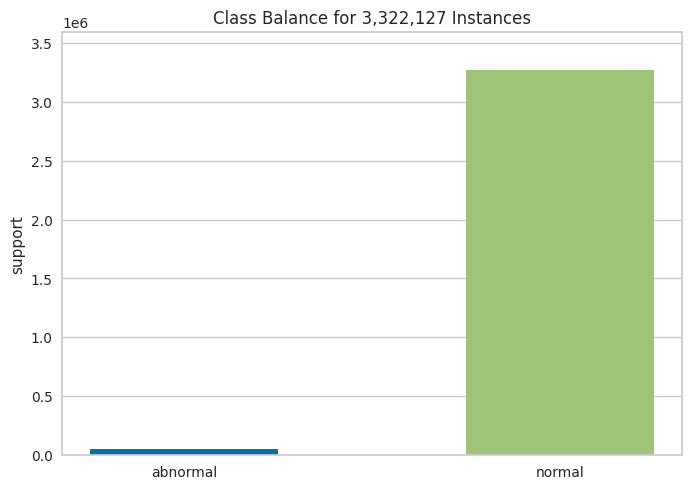

ClassBalance(ax=<Axes: title={'center': 'Class Balance for 3,322,127 Instances'}, ylabel='support'>)

In [10]:
# Plotting the class distributions for the full training data
class_balance(df['Target'])

From the above diagram it can be seen that the data is ***severely skewed***, which was expected as most time normal log are experienced more than abrnomal logs.<br>
Furthermore, due to the substantial size of the dataset containing approximately three million instances, conducting a comprehensive analysis would be time and compute intensive . To expedite computational processes, we will extract a representative subsample for the EDA continuation, allowing for a more manageable and efficient exploration. <br> 
In order to ensure a proportional representation of various categories within the dataset, we will employ the Stratified Sampling Technique. This method strategically selects samples from each category, preserving the distribution and enabling us to work with a well-rounded subset of the data.

In [11]:
X_train, _, Y_train, _ = train_test_split(df['Log'], df['Target'], random_state= 23, test_size=0.75,
                                                    stratify=df['Target'])
print(f" After stratified sampling method,  the data sample is reduced to {X_train.shape[0]}")

 After stratified sampling method,  the data sample is reduced to 830531


In [12]:
df = pd.DataFrame()
df['Log'] = X_train
df['Target'] = Y_train
df.reset_index(inplace=True)
df.drop(['index'], axis = 1,inplace= True)
df.head()

,Log,Target
0,1122147236 2005.07.23 R00-M1-N6-C:J08-U11 200...,normal
1,1120092051 2005.06.29 R04-M0-NE-C:J10-U11 200...,normal
2,1120917289 2005.07.09 R12-M1-N3-C:J10-U01 200...,normal
3,1120146573 2005.06.30 R00-M0-N5-C:J07-U01 200...,normal
4,1118773076 2005.06.14 R21-M1-N9-C:J15-U11 200...,normal


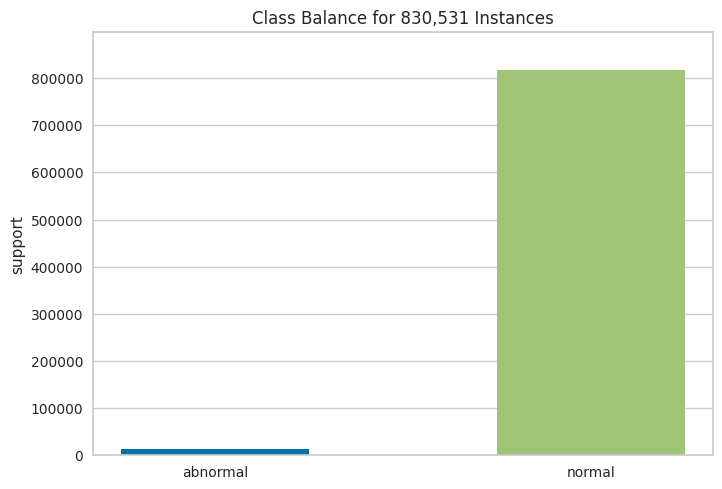

ClassBalance(ax=<Axes: title={'center': 'Class Balance for 830,531 Instances'}, ylabel='support'>)

In [13]:
# Sample class Distribtution
class_balance(df['Target'])

<a id="ch3"></a>
### Step 3 - Decoding Textual Patterns: Statistical Analysis
Text statistics analysis and visualizations encompass straightforward yet remarkably insightful methodologies that provide a profound understanding of the underlying text data. These techniques include word frequency analysis, sentence length analysis, and average word length analysis, all of which collectively contribute to unraveling the fundamental characteristics embedded within the textual content.<br>

Character and Sentence length analysis, on the other hand, examines the distribution of sentence lengths across the dataset. This exploration aids in gauging the complexity of the text and its overall readability. By understanding the variation in sentence lengths, we can assess the pacing and structure of the content, offering insights into the log text.<br>

Average word length analysis provides additional granularity by calculating the average number of characters per word in the log text. This metric can offer insights into the text's level of technicality, formality, or even the language it is composed in.<br>

Collectively, these text statistics analysis and visualizations serve as foundational tools for comprehending the nuances of textual data. They empower researchers and analysts to unearth valuable patterns, trends, and hidden information, enabling a more informed and data-driven approach to subsequent analyses and modeling.

In [14]:
#Generating the Character length and Average word length
df["Character_Length"] = df["Log"].str.len()
df["Word_Length"] = df["Log"].str.split().map(lambda x: len(x))
df["Avg Word"] = df["Log"].str.split().apply(lambda x: [len(i) for i in x]).map(lambda x: np.mean(x))
df.head()

,Log,Target,Character_Length,Word_Length,Avg Word
0,1122147236 2005.07.23 R00-M1-N6-C:J08-U11 200...,normal,145,13,10.076923
1,1120092051 2005.06.29 R04-M0-NE-C:J10-U11 200...,normal,127,10,11.600000
2,1120917289 2005.07.09 R12-M1-N3-C:J10-U01 200...,normal,127,10,11.600000
3,1120146573 2005.06.30 R00-M0-N5-C:J07-U01 200...,normal,126,10,11.500000
4,1118773076 2005.06.14 R21-M1-N9-C:J15-U11 200...,normal,143,14,9.142857


In [15]:
print(f"Character Length ranges from {df['Character_Length'].min()} to {df['Character_Length'].max()} over the text corpus")
print(f"Word Length ranges from {df['Word_Length'].min()} to {df['Word_Length'].max()} over the text corpus")
print(f"Maximum character length is {df['Character_Length'].max()} and Minimum charater length is {df['Character_Length'].min()} over the text corpus")
print(f"Maximum word length is {df['Word_Length'].max()} and Minimum word length is {df['Word_Length'].min()} over the text corpus")

Character Length ranges from 94 to 928 over the text corpus
Word Length ranges from 8 to 101 over the text corpus
Maximum character length is 928 and Minimum charater length is 94 over the text corpus
Maximum word length is 101 and Minimum word length is 8 over the text corpus


Creating histogram diagrams to visualize the distribution of character lengths and word lengths provides a clear and insightful perspective into the textual data. These visualizations offer a comprehensive overview of the variations in text composition, shedding light on key characteristics that might otherwise remain unnoticed

array([[<Axes: title={'center': 'Character_Length'}>,
        <Axes: title={'center': 'Word_Length'}>]], dtype=object)

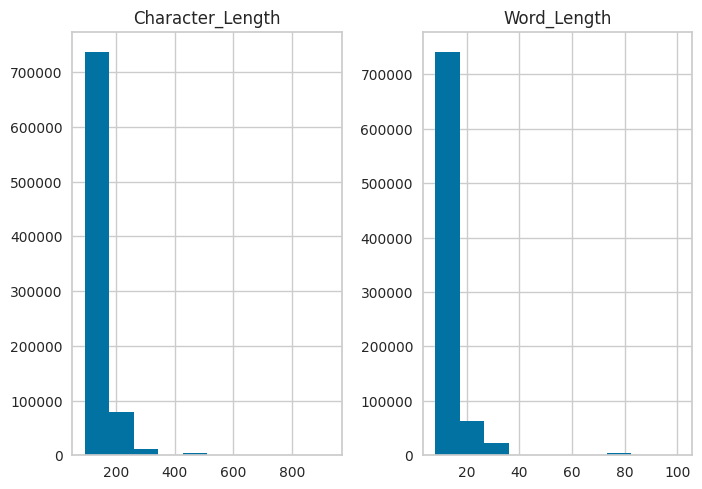

In [16]:
cleaned_stats_columns = ['Character_Length', 'Word_Length']
df.hist(column=cleaned_stats_columns, grid=True)

The diagram provided above reveals a significant trend: a substantial majority of the log text entries exhibit a character length below 200 and a word length below 20. This observation underscores a prevalent compactness in the textual content, suggesting that the majority of log messages are relatively concise. This insight holds implications for potential brevity of information conveyed, and even potential constraints on the depth of context provided within each log entry.<br>

<a id="ch4"></a>
### Step 4 - Uncovering Language Patterns: Word Frequ Stopwords and N-grams

Word frequency analysis delves into the occurrences of individual words throughout the text, allowing us to identify dominant terms, common themes, and potentially significant keywords. This analysis provides valuable insights into the core themes and word relationship present within the text corpus, shedding light on its primary focus.<br>


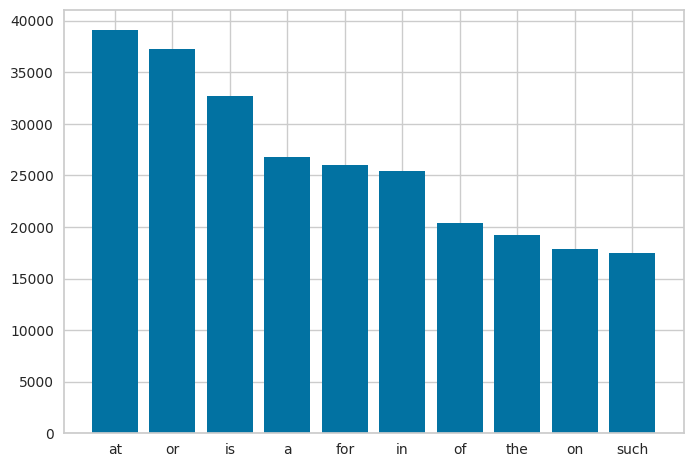

In [17]:
plot_top_stopwords_barchart(df['Log'])

From the chart above, it could been seen that the stop-words make a large part of the text corpus. Stop words are commonly occurring words in a language that are often filtered out during text analysis due to their limited contribution to the overall meaning of a sentence or document.<br>
These words, such as "the", "is" ,"at" and "in" hold minimal informational value and are used to connect meaningful words. While essential for grammar and sentence structure, stop words provide little relevance and usefulness when trying to identify significant patterns, themes, or topics within a text. Therefore, excluding them helps focus the analysis on the more meaningful and informative content, enhancing the accuracy and interpretability of the results.<br>

In [18]:
df['Log'] = df['Log'].apply(clean_text_data)
df["Cleaned_Character_Length"] = df["Log"].str.len()
df["Cleaned_Word_Length"] = df["Log"].str.split().map(lambda x: len(x))
df["Cleaned_Avg Word"] = df["Log"].str.split().apply(lambda x: [len(i) for i in x]).map(lambda x: np.mean(x))
df.head()

,Log,Target,Character_Length,Word_Length,Avg Word,Cleaned_Character_Length,Cleaned_Word_Length,Cleaned_Avg Word
0,rmncju rmncju ras kernel info floating point a...,normal,145,13,10.076923,65,9,6.333333
1,rmnecju rmnecju ras kernel info generating core,normal,127,10,11.600000,47,7,5.857143
2,rmncju rmncju ras kernel info generating core,normal,127,10,11.600000,45,7,5.571429
3,rmncju rmncju ras kernel info generating core,normal,126,10,11.500000,45,7,5.571429
4,rmncju rmncju ras kernel fatal floating pt ex ...,normal,143,14,9.142857,57,10,4.800000


In [19]:
print("The following are for the cleaned words")
print(f"Character Length ranges from {df['Cleaned_Character_Length'].min()} to {df['Cleaned_Character_Length'].max()}")
print(f"Word Length ranges from {df['Cleaned_Word_Length'].min()} to {df['Cleaned_Word_Length'].max()}")
print(f"Maximum character length is {df['Character_Length'].max()} and Minimum charater length is {df['Character_Length'].min()}")
print(f"Maximum word length is {df['Word_Length'].max()} and Minimum word length is {df['Word_Length'].min()}")

The following are for the cleaned words
Character Length ranges from 29 to 648
Word Length ranges from 5 to 56
Maximum character length is 928 and Minimum charater length is 94
Maximum word length is 101 and Minimum word length is 8


array([[<Axes: title={'center': 'Cleaned_Character_Length'}>,
        <Axes: title={'center': 'Cleaned_Word_Length'}>]], dtype=object)

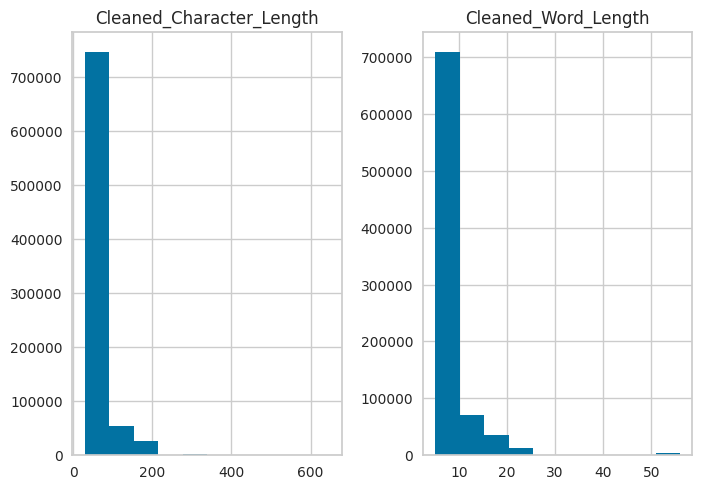

In [20]:
cleaned_stats_columns = ['Cleaned_Character_Length', 'Cleaned_Word_Length']
df.hist(column=cleaned_stats_columns, grid=True)

Examining the most frequent n-grams can provide a richer understanding of the contextual usage of words within a text. N-grams are contiguous sequences of n items, typically words in the case of text analysis. By analyzing and visualizing the top n-grams through a bar chart, one can gain insights into the specific phrases and word combinations that frequently co-occur.<br>

This approach offers a more nuanced view of how words are utilized within their surrounding context. N-grams capture not only single words but also reveal patterns of language usage, idiomatic expressions, and specific syntactical structures. Plotting a top n-gram bar chart showcases these recurring phrases, shedding light on the ways in which words interact and contribute to the overall meaning.<br>

In essence, investigating prominent n-grams enables a deeper exploration of the intricate relationships between words. This analysis is particularly valuable for capturing nuances, disambiguating word meanings, and grasping the subtle shifts in language usage that might go unnoticed when examining isolated words. As a result, it contributes to a more holistic and accurate interpretation of the text's content and intention.

Text(0.5, 1.0, 'Top Words')

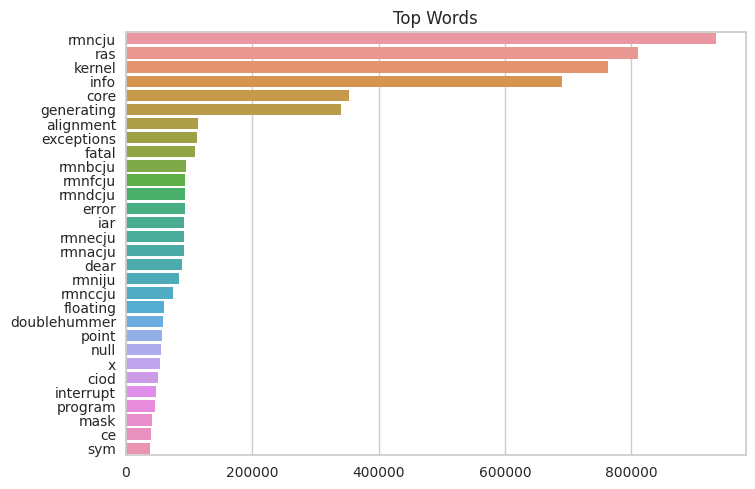

In [21]:
plot_top_word_barchart(df['Log'], title_= '')

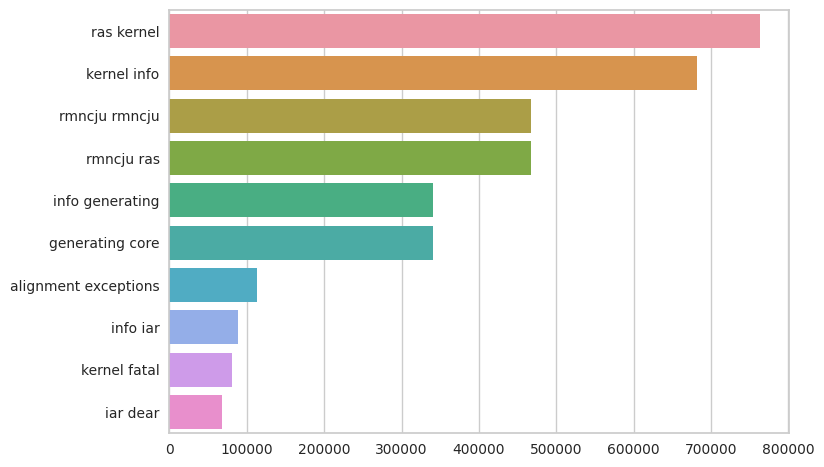

In [22]:
plot_top_ngrams_words_barchart(df['Log'])

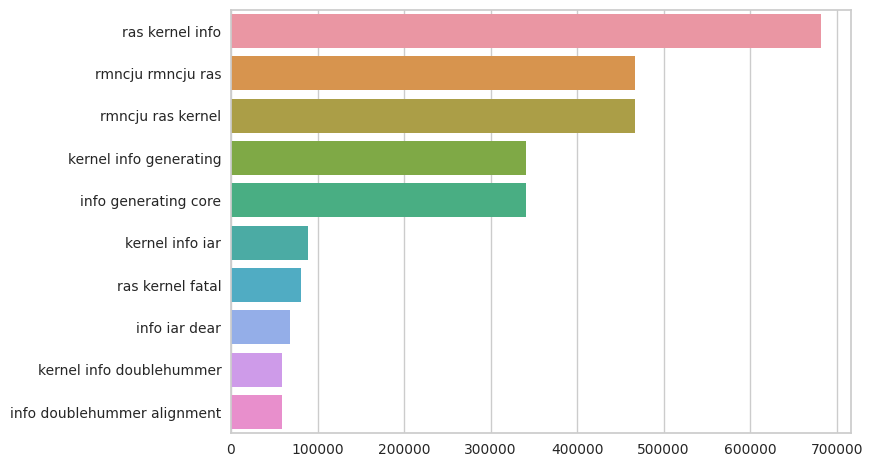

In [23]:
plot_top_ngrams_words_barchart(df['Log'],no_grams= 3)

The ensemble of diagrams showcased above presents an abundance of valuable insights waiting to be unearthed.

The initial diagram, which illustrates the top words within the corpus, adopts the form of a bar chart, spotlighting the most frequently occurring individual words (unigrams) in the dataset. Yet, upon closer examination, it becomes apparent that the top 30 words offer limited substantial context. This grouping predominantly comprises terms like 'mncju,' 'mnecju,' and 'rmniju,' which seem to be concatenated codes formed after the elimination of numbers during the data cleaning process. <br>

The subsequent bar charts representing bigrams and trigrams exhibit resemblances to the top words diagram. While distinguished by their respective word combinations, these visualizations unveil recurrent patterns within two-word and three-word sequences.<br> Much like the top words chart, these n-gram displays mirror the distinct nature of the log data, emphasizing the prevalence of concatenated codes. Cumulatively, these diagrams underscore the intricacies associated with comprehending software log messages, emphasizing the necessity for a profound grasp of the domain and the contextual environment in which these logs originate.

<a id="ch6"></a>

### Step 5 - From Analysis to Action: Key Objective Takeaway and  Charting Next Steps


# TODO


1. **Analyzing Text Characteristics:**
   
   Delving into the intricacies of the text data, this analysis encompasses aspects such as word frequency, sentence length, and n-gram patterns. By dissecting these textual attributes, we gain insights into the composition and context of the data.

2. **Unveiling Key Observations:**

   The results reveal that the majority of log entries display a compact character and word length. However, top words, bigrams, and trigrams predominantly consist of concatenated codes, underscoring the specialized nature of software log messages.

3. **Challenges in Interpretation:**

   The analysis highlights the challenge of interpreting the logs' content due to their technical language and specialized syntax. The presence of concatenated codes complicates comprehension, necessitating domain expertise for accurate understanding.

4. **Key Objective Takeaway:**

   The primary objective of this analysis is to inform the extent to which software logs can be understood through basic text analysis. While characterizing the nature of the logs, the takeaway is that deciphering them requires a nuanced approach that accounts for the unique characteristics and challenges presented by these logs.

5. **Next Steps and Conclusions:**

   Moving forward, in-depth domain knowledge and context-aware techniques will be essential for effective log interpretation. Further exploration involving advanced NLP methodologies, topic modeling, and anomaly detection could enhance our ability to extract valuable insights from these logs. The analysis underscores the importance of a collaborative approach between domain experts and data analysts to draw meaningful conclusions from intricate software log data.